In [33]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
df = pd.read_csv("./data_ML/incendi_liguria.csv")
pd.__version__
mapping = {"LA SPEZIA": 1, "GENOVA": 2, "SAVONA": 3, "IMPERIA": 4}
df = df.replace({"provincia": mapping})

In [16]:
df.head()

giorno  mese  anno  stagione        data  area_ha  non_veg  coltivi  prati  \
0       3     1  1997         1  1997-01-03  2.46640      0.0      0.0    0.0   
1       9     1  1997         1  1997-01-09  3.34080      0.0      0.0    0.0   
2      12     1  1997         1  1997-01-12  3.14875      0.0      0.2    0.0   
3      13     1  1997         1  1997-01-13  4.57335      0.0      0.0    0.0   
4      13     1  1997         1  1997-01-13  1.20470      0.0      0.0    0.0   

   oliveti  pinete  latifoglie  castagneti  arbusti  altro  provincia  \
0     0.00    0.00        0.00        1.60     0.96    0.0          4   
1     0.00    0.12        0.00        0.00     3.08    0.0          4   
2     1.68    0.00        0.00        0.00     1.20    0.0          4   
3     0.00    0.00        0.16        4.44     0.00    0.0          2   
4     0.00    0.00        0.00        1.20     0.00    0.0          2   

              comune  
0  COSIO DI ARROSCIA  
1        VENTIMIGLIA  
2            DOLCEDO  
3            DAVAGNA  
4             GENOVA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5964 entries, 0 to 5963
Data columns (total 17 columns):
giorno        5964 non-null int64
mese          5964 non-null int64
anno          5964 non-null int64
stagione      5964 non-null int64
data          5964 non-null object
area_ha       5964 non-null float64
non_veg       5964 non-null float64
coltivi       5964 non-null float64
prati         5964 non-null float64
oliveti       5964 non-null float64
pinete        5964 non-null float64
latifoglie    5964 non-null float64
castagneti    5964 non-null float64
arbusti       5964 non-null float64
altro         5964 non-null float64
provincia     5964 non-null int64
comune        5964 non-null object
dtypes: float64(10), int64(5), object(2)
memory usage: 792.2+ KB


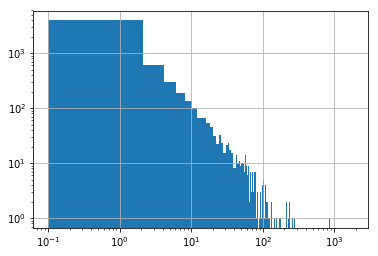

In [17]:
df.info()
df = df.drop(["comune",  "giorno", "mese","anno", "data"], axis = 1)
fig, ax = plt.subplots()

df["area_ha"].hist(ax=ax, bins = 900)
ax.set_yscale('log')
ax.set_xscale("log")

In [18]:
threshold = 10
df["isbig"] = df["area_ha"] > threshold



In [19]:
df = df.astype({'isbig': 'int32'})
df.head()


stagione  area_ha  non_veg  coltivi  prati  oliveti  pinete  latifoglie  \
0         1  2.46640      0.0      0.0    0.0     0.00    0.00        0.00   
1         1  3.34080      0.0      0.0    0.0     0.00    0.12        0.00   
2         1  3.14875      0.0      0.2    0.0     1.68    0.00        0.00   
3         1  4.57335      0.0      0.0    0.0     0.00    0.00        0.16   
4         1  1.20470      0.0      0.0    0.0     0.00    0.00        0.00   

   castagneti  arbusti  altro  provincia  isbig  
0        1.60     0.96    0.0          4      0  
1        0.00     3.08    0.0          4      0  
2        0.00     1.20    0.0          4      0  
3        4.44     0.00    0.0          2      0  
4        1.20     0.00    0.0          2      0

In [20]:
df  =  df.drop(["area_ha"], axis=1)
from sklearn.tree import DecisionTreeClassifier
RSEED  = 500
tree = DecisionTreeClassifier(random_state=RSEED)
features = list(df.columns[:-1])
features


from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('isbig'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)





#y = df["isbig"]
#X = df[features]

tree.fit(train,train_labels)

print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

from sklearn.tree import export_graphviz

# Export as dot
export_graphviz(tree, 'tree.dot', rounded = True, 
                feature_names = features, 
                class_names = ['0', '1'], filled = True)

from subprocess import call
# Convert to png
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=100']);



from IPython.display import Image
Image('tree.png')


Decision tree has 487 nodes with maximum depth 34.


In [26]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)


from collections import Counter
print(Counter(probs))
print(Counter(predictions))


Counter({0.0: 1436, 1.0: 217, 0.08064516129032258: 34, 0.05263157894736842: 34, 0.045454545454545456: 30, 0.06521739130434782: 17, 0.2: 6, 0.125: 5, 0.1111111111111111: 3, 0.16666666666666666: 3, 0.1: 2, 0.5: 2, 0.3333333333333333: 1})
Counter({0: 1573, 1: 217})


In [27]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')



Train ROC AUC Score: 0.9986856563758284
Test ROC AUC  Score: 0.8553974998946882


In [28]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.72 Train: 0.95
Precision Baseline: 0.14 Test: 0.82 Train: 1.0
Roc Baseline: 0.5 Test: 0.86 Train: 1.0


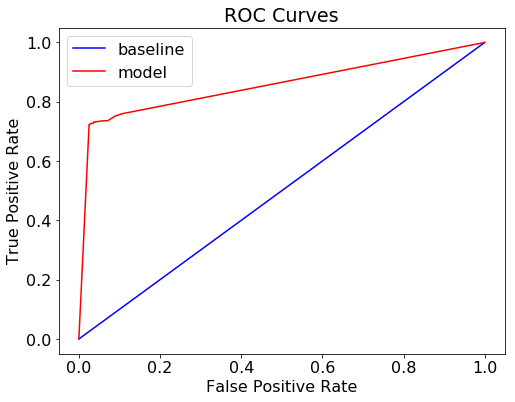

In [29]:
evaluate_model(predictions, probs, train_predictions, train_probs)

In [31]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)


Confusion matrix, without normalization
[[1505   39]
 [  68  178]]


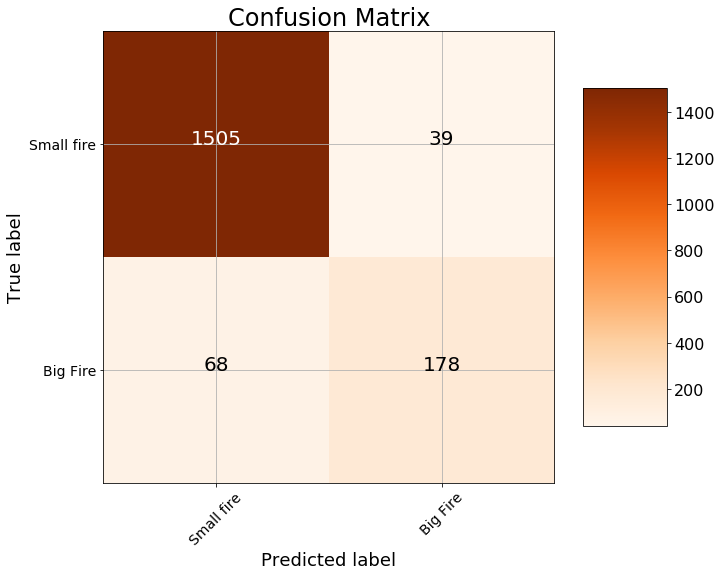

In [32]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Small fire', 'Big Fire'],
                      title = 'Confusion Matrix')